# Machine Learning technique on PET block detector development - Part 2-2

## Crystal/Pixel discrimination for DQS PET block detector using Machine Learning techniques (v1.0, 2019-09)   
## (Continued from Part 2-1)
### SVM extra test - part 1, full data set fitting
* In this extra test, we will test the performance of the SVM classifier with the whole set of the data with preprocessed input variables.
---

In [2]:
# load libraries

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib
from sklearn import metrics
import time

from sklearn.svm import SVC


plt.rcParams['figure.dpi'] = 120 # default is 72


# re-load data

file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\ML_data\\new_concept_block_15x15_sorted_events1.csv"
df0 = pd.read_csv (file, comment='#')

X = df0.iloc[:,4:].values
decoding = df0.iloc[:,0:4].values

E_top = X[:,0:18]
E_bottom = X[:,18:36]

E_x1 = E_top[:, 0:18:2]
E_x2 = E_top[:, 18:0:-2]

E_y1 = E_bottom[:, 0:18:2]
E_y2 = E_bottom[:, 18:0:-2]

E_left = np.sum(E_x1, axis = 1)
E_right = np.sum(E_x2, axis = 1)

E_front = np.sum(E_y1, axis = 1)
E_back = np.sum(E_y2, axis = 1)



infile = open('./pickle/temp_data1','rb')
X_t, X_b, X_a, X_g, X_c, index_train, index_test = pickle.load(infile)
infile.close()


# pixel_xy = np.array(df0['index_y'] * 15 + df0['index_x'])
pixel_x = np.array(df0['index_x'])
pixel_y = np.array(df0['index_y'])
pixel_xy = pixel_y * 15 + pixel_x

pixel_x_train = pixel_x[index_train]
pixel_y_train = pixel_y[index_train]
pixel_xy_train = pixel_xy[index_train]

pixel_x_test = pixel_x[index_test]
pixel_y_test = pixel_y[index_test]
pixel_xy_test = pixel_xy[index_test]

In [3]:
from sklearn.utils import check_random_state

def random_cmap(ncolors=256, random_state=None):
    """
    Generate a matplotlib colormap consisting of random (muted) colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    """

    from matplotlib import colors

    prng = check_random_state(random_state)
    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.4, high=0.9, size=ncolors)
    v = prng.uniform(low=0.7, high=1.0, size=ncolors)
    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)



In [4]:

def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

In [5]:
def plot_prediction_boundary3(reg_func, cmap='hsv', alpha=1, axes=[0, 1.0, 0, 1.0], title='', ax=None, precision=32):
    '''
    fitting the data with one function, the prediction is the unique pixel index
    '''
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], precision)
    x2s = np.linspace(axes[2], axes[3], precision)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    pixel_xy_pred = reg_func.predict(X_new).reshape(x1.shape)

    lut_pred = pixel_xy_pred
    ax.imshow(lut_pred, alpha=alpha, cmap=cmap)
    ax.set_title(title)
    
    return lut_pred


In [9]:
def test_svm1(X, y, index_train, index_test, kernel='linear', notes=''):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    clf = SVC(kernel=kernel, random_state=1)
    clf.fit(X_train, y[index_train])
    
    datafile = open('./pickle/SVC_fitting_model_'+kernel+'_'+notes,'wb')
    temp_data = {'X':X, 'pixel_xy':pixel_xy, 'index_train':index_train, \
                 'index_test':index_test, 'fitting_data_length':fitting_data_length, \
                 'testing_data_length':testing_data_length, 'model':clf}
    pickle.dump(temp_data, datafile)
    datafile.close()
    
    pixel_xy_pred = clf.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    
    print('accuracy score: %f' % (metrics.accuracy_score(y[index_test], pixel_xy_pred)))
        
    return clf


=== Anger docoding ===
accuracy score: 0.408781
Processing time for fitting 53934.414742 sec


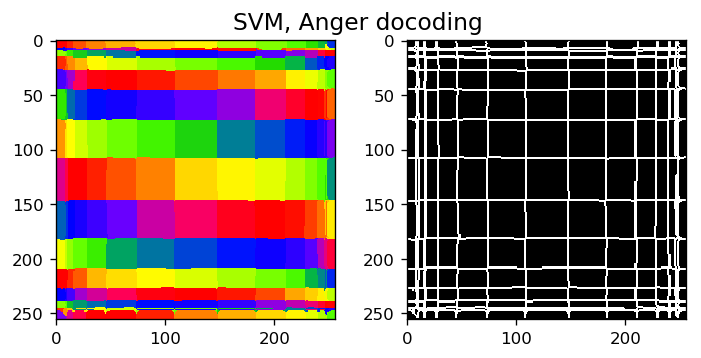

Processing time for predicting 15049.133118 sec
=== light channel ===
accuracy score: 0.485991
Processing time for fitting 54709.050988 sec


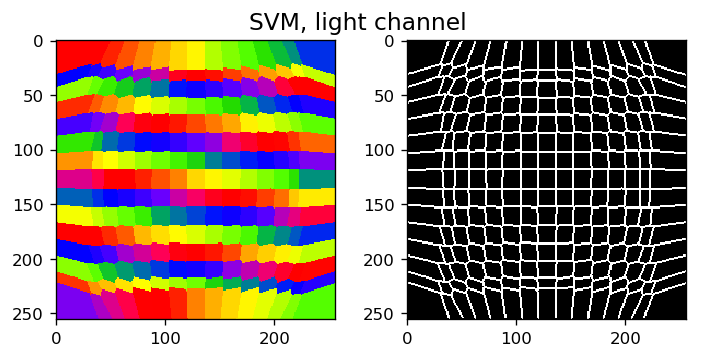

Processing time for predicting 15291.979080 sec


In [14]:
#fig, ax = plt.subplots(2,5, figsize=(15, 6))
#fig.suptitle("SVM, ", fontsize=16)
#fig.tight_layout()
#fig.subplots_adjust(top=0.9)
import pickle


#fitting_data_length = 1000
#testing_data_length = 1000
fitting_data_length = len(index_train)
testing_data_length = len(index_test)
kernel='linear'

#for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
#                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
#                 (X_c,'Complex weight function')) ):
for index, (X, notes) in enumerate( ((X_t,'Anger docoding'),(X_b,'light channel')) ):

    fig, ax = plt.subplots(1,2, figsize=(6, 3))
    fig.suptitle("SVM, " + notes, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    
    print ('=== %s ==='%notes)
    t0 = time.time()
    clf1 = test_svm1(X, pixel_xy, index_train[:fitting_data_length], index_test[:testing_data_length], kernel=kernel, notes=notes)
    t1 = time.time()
    print ('Processing time for fitting %f sec'%(t1-t0))
    t0 = t1
    lut_pred = plot_prediction_boundary3(clf1, cmap='prism', ax=ax[0], precision=256)
    ax[1].imshow(generate_grid(lut_pred), cmap='gray')
    filename = './figs2/SVC_fitting_model_'+kernel+'_'+notes+'.png'
    plt.savefig(filename, dpi=300)

    plt.show()

    t1 = time.time()
    print ('Processing time for predicting %f sec'%(t1-t0))
    
    

* <b>SVM fitting is very slow, the fitting for the whole trainning data set (~900k) take 24+ hours with only input two variables!</b>   
For example, the time for the fitting of all data set and the time for the predicting of 256x256 data points is:   
>>
=== Anger docoding ===  
accuracy score: 0.408781  
Processing time for fitting 53934.414742 sec  
Processing time for predicting 15049.133118 sec  
=== light channel ===  
accuracy score: 0.485991  
Processing time for fitting 54709.050988 sec  
Processing time for predicting 15291.979080 sec  
  
* <b>Even with the whole data set, the accuracy of the SVM fitting with linear kernel and precessed input variables is only 0.41 which is much worse than what we achieved with the conventional lookup table method or other ML algorighms such as the Tree classification, etc.</b>
> This poor performance can be explained with one of the important advantages of SVM which is that it works more effectively in high dimensional spaces. However, the input variables in the study above have only two dimensions.